# Poisson Neuron Model
This model treats each neuron as a Poisson process, with the expected number of firing events per timestep is controlled by a per-cell parameter $f$. The Poisson distribution is not an ideal choice because of refractory periods, depression, and other such effects which mean that spikes are not independent, but hopefully it is a useful first pass.

In [5]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

In [64]:
Tmax = 1001
Ncells = 500
sigma = 0.5

Tspike = np.random.lognormal(mean=np.log(25) - sigma**2/2, sigma=sigma, size=Ncells)
fspike = np.random.lognormal(mean=np.log(40/1000) - sigma**2/2, sigma=sigma, size=Ncells)

firings = np.random.poisson(lam=fspike, size=(Tmax, Ncells))

<IPython.core.display.Javascript object>


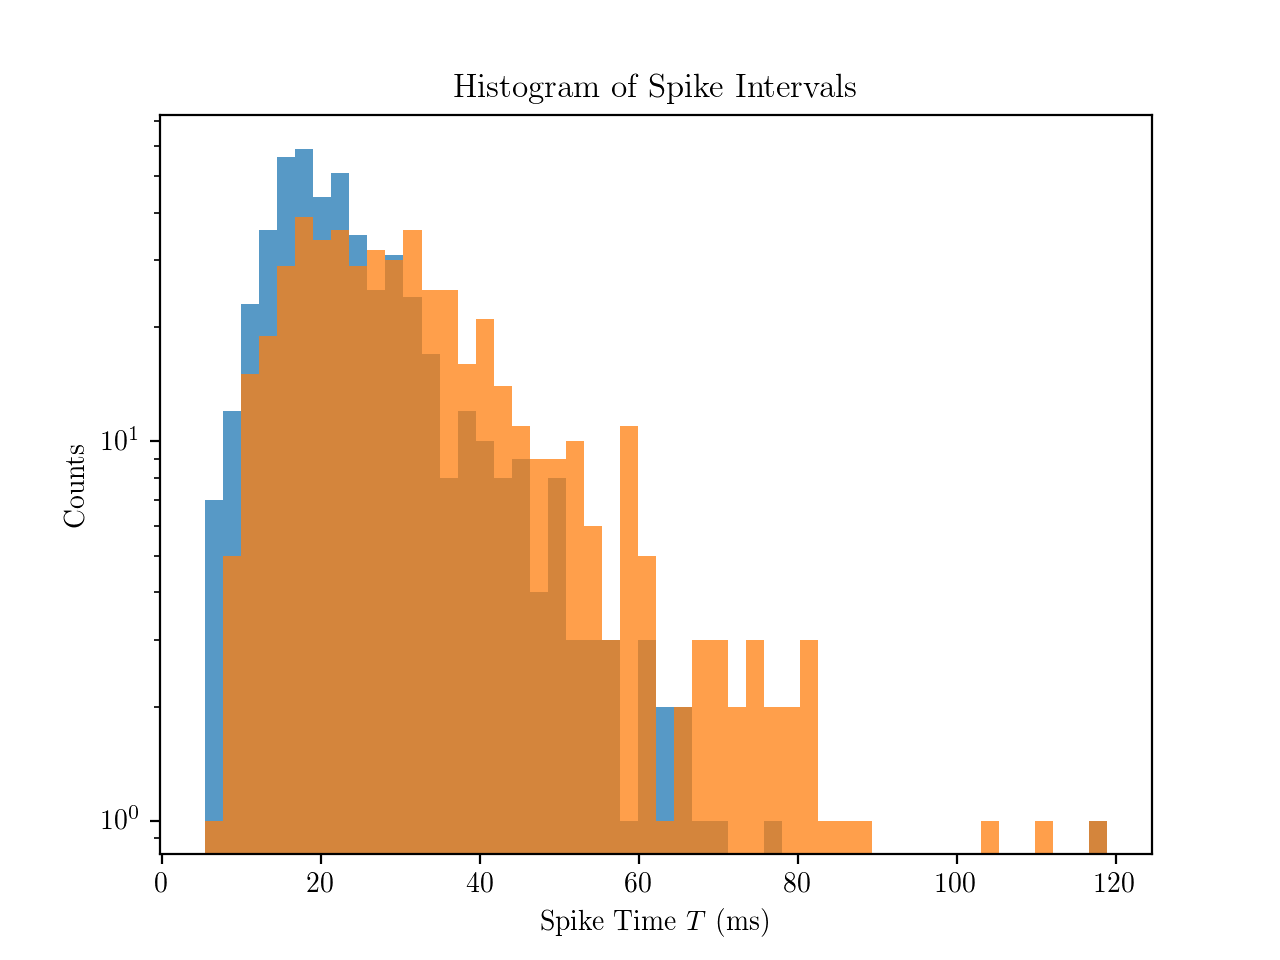

In [65]:
# Sanity check: histogram of interspike intervals.
plt.figure()
_, bins, _ = plt.hist(Tspike, 50, label='Lognormal Interval',
                      alpha=0.75, normed=False, log=True)
plt.hist(1/fspike, bins, label='Lognormal Frequency',
         alpha=0.75, normed=False, log=True)
plt.title('Histogram of Spike Intervals')
plt.xlabel('Spike Time $T$ (ms)')
plt.ylabel('Counts')

<IPython.core.display.Javascript object>


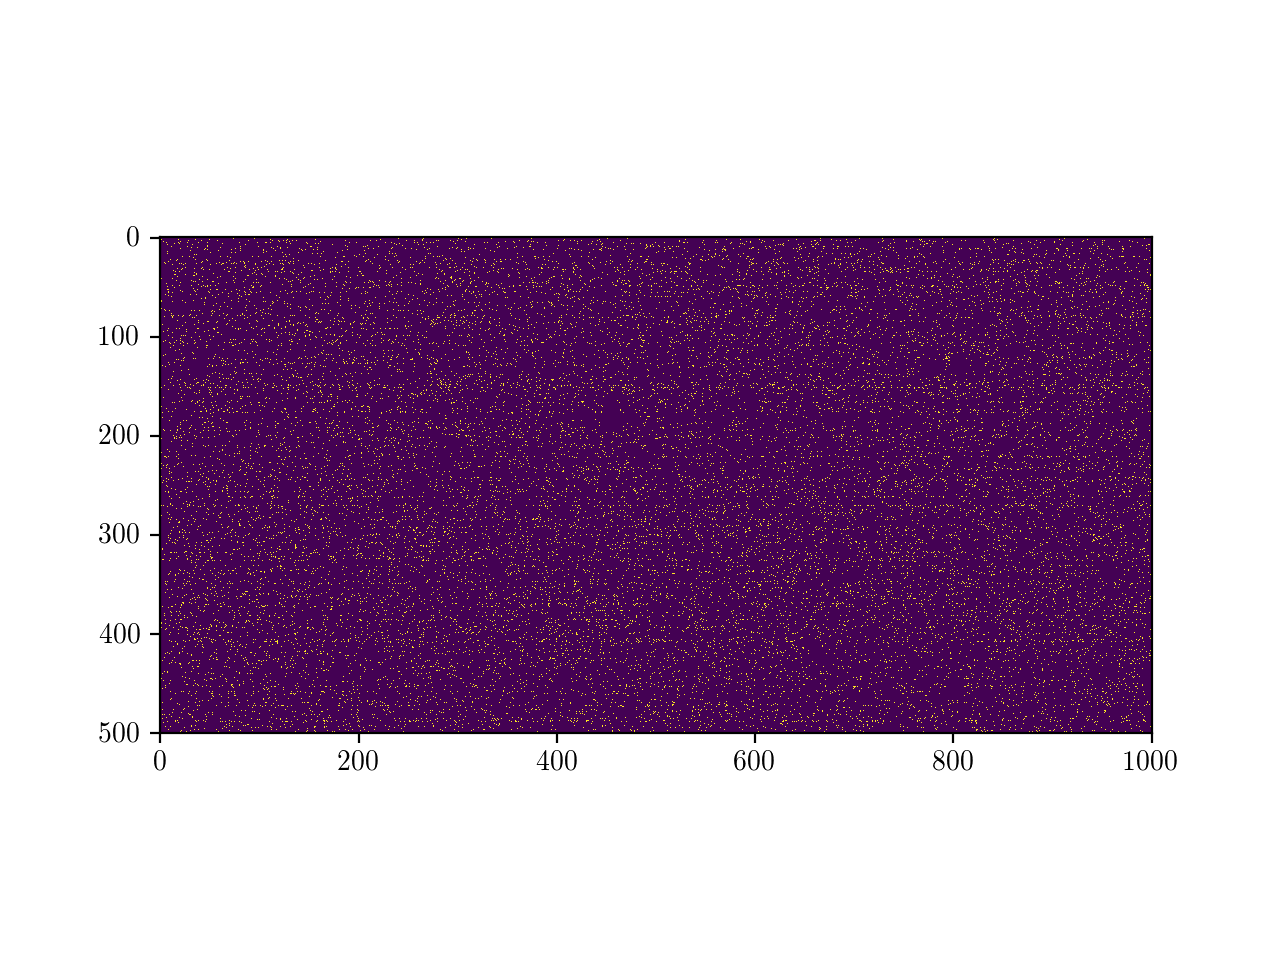

In [66]:
plt.figure()
plt.imshow(firings.T > 0)